<a href="https://colab.research.google.com/github/Jon-nas/Rede-Neural/blob/main/Rede_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn as nn, optim

In [11]:
transform = transforms.ToTensor() #definindo a conversão de imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) #carrega a parte do treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) #cria um buffer para carregar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) #carrega a parte de validação do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) #cria um buffer para carregar os dados por partes

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 40504212.80it/s]


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1190593.00it/s]


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9425007.46it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8952316.15it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



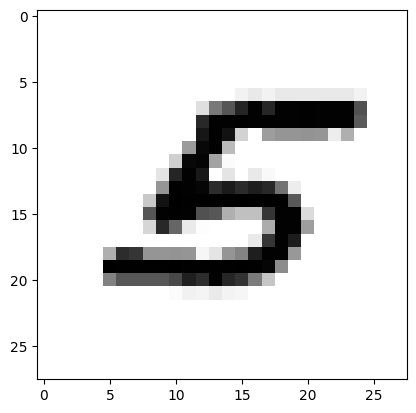

In [12]:
dataiter = iter(trainloader)
imagens, etiquetas = dataiter.__next__()
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')


In [13]:
print(imagens[0].shape) #para verificara as dimensões do tensor de cada imagem
print(etiquetas[0].shape) #para verificar as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [14]:
class Modelo(nn.Module):
  def __init__(self):
    super(Modelo, self).__init__()
    self.linear1 = nn.Linear(28*28, 128) #camada de entrada, 784 neurônios que se ligam a 128
    self.linear2 = nn.Linear(128, 64) #camada interna 1, 128 neurônios que se ligam a 64
    self.linear3 = nn.Linear(64, 10) #camada interna 2, 6 neurônios que se ligam a 10
    #para a camada de saida não é necessario definir nada pois so precisamos pegar o output da camada interna 2

    def forward(self, x):
      x = F.relu(self.linear1(x)) #função de ativação da camada de entrada para a camada interna 1
      x = F.relu(self.linear2(x)) #função de ativação da camada interna 1 para a camada interna 2
      x = self.linear3(x) #função de ativação da camada interna 2 para a camada de saida, nesse caso f(x) = x
      return F.log_softmax(x, dim=1) #dados utilizados para calcular a perda

In [15]:
def treino(modelo, trainloader, device):

  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) #define a política da atualização dos pesos e das baias
  inicio = time() #timer para saber quanto tempo levou o treino

  criterio = nn.NLLLoss() #definindo o critério para calcular a perda
  EPOCHS = 10 #numero de epochs que o algorítmo rodará
  modelo.train() #ativando o modo de treinamento do modelo

  for epoch in range(EPOCHS):
    perda_acumulada = 0 #inicialização da perda acumuluda da epoch em questão

    for imagens, etiquetas in trainloader:

      imagens = imagens.view(imagens.shape[0], -1) #convertendo as imagens para "vetores" de 28*28 casas para ficarem compativeis com a rede
      otimizador.zero_grad() #zerando os gradientes por conta do ciclo anterior

      output = modelo(imagens.to(device)) #colocando os dados no  modelo
      perda_instantanea = criterio(output, etiquetas.to(device)) #calculando a perda da epoch em questão

      perda_instantanea.backward() #back propagation a partir da perda

      otimizador.step() #atualizando os pesos e as baias

      perda_acumulada += perda_instantanea.item() #atualização a perda acumulada

    else:
      print("Epoch {} - Perda resultante: {}".format(epoch + 1, perda_acumulada / len(trainloader)))

      print("\nTempo de treino (em minutos) =", (time() - inicio) / 60)

In [16]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784)
      #desativar o autograd para a validação. Grafos computacionais dinâmicos tem u alto custo de processamento
      with torch.no_grad():
        logps = modelo(img.to(device)) #output do modelo em escala logaritmica


      ps = torch.exp(logps) #converter output para escala normal(lembrando que é um tensor)
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab)) #converter o tensor em número, no caso, o número que o modelo previu como correta
      etiqueta_certa = etiquetas.numpy()[i]
      if (etiqueta_certa == etiqueta_pred): #comparar a previsão com o valor correto
        conta_corretas += 1
        conta_todas += 1

  print("Total de imagens testadas =", conta_todas)
  print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))

In [17]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)